In [7]:
! pip install --upgrade openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.0 MB/s eta 0:00:00


In [8]:
# imports
import openai
import os
import json
import time
import ast
from openai import OpenAI

In [9]:
# constants
tickers_list = ['NVDA', 'AMD', 'PLTR', 'DUOL', 'BYND']
articles_data_path = "/content/stock_summary_data.json" # TO DO: upload this to repo
custom_prompt_selector = {
    "beginner": [False, "Provide stock analysis for a beginner investor including the revenue model, business stand and position in the market. "],
    "expert": [True, "Provide stock analysis for an expert investor including the risk factor by classifying it among High, low or medium; returns expected in high(greater than 15% per annum), medium(between 5% to 15% per annum) ,low(less than 5% per annum); Suggested investment duration among short term(within months) or longterm(within years). For every every decision you make provide a reason correleating it with stock price and market perfromance. "],
    "SWOT": [True, "Include SWOT analysis, by listing top 3 strengths, weaknesses, Opportunities and Threats. If possible add if the above points are for short term or long term. "],
    "competitive": [False, "Compare the current stock and its potential competitor interms of 'Market size', 'revenue stream', their strengths. For every comparison provide which stock is better. And in the end provide which stock is better based on your overall analysis. "]
}
os.environ["OPENAI_API_KEY"] = "YOUR-OPEN-API-KEY"

In [25]:
# TO DO:  fetch from frontend
current_ticker = 'BYND'
new_custom_prompt_selector = custom_prompt_selector.copy()
# TO DO: Based on frontend input
# new_custom_prompt_selector["beginner"] =
# new_custom_prompt_selector["expert"] =
# new_custom_prompt_selector["SWOT"] =
# new_custom_prompt_selector["competitive"] =

In [13]:
# construct prompt based on user input
def get_final_prompt(new_custom_prompt_selector):
    final_prompt = ""
    for prompt_type in new_custom_prompt_selector:
        if custom_prompt_selector[prompt_type][0]:
            final_prompt = final_prompt + custom_prompt_selector[prompt_type][1]
    print(final_prompt)
    return final_prompt
final_prompt = get_final_prompt(new_custom_prompt_selector)

Provide stock analysis for an expert investor including the risk factor by classifying it among High, low or medium; returns expected in high(greater than 15% per annum), medium(between 5% to 15% per annum) ,low(less than 5% per annum); Suggested investment duration among short term(within months) or longterm(within years). For every every decision you make provide a reason correleating it with stock price and market perfromance. Include SWOT analysis, by listing top 3 strengths, weaknesses, Opportunities and Threats. If possible add if the above points are for short term or long term. 


In [15]:
news_articles_prompt = "You are stock news analyzer. Store key content of the news that impacts profit and loss of the company, Strengths, weaknesses, opportunities, threats."
prompt_to_combine = "Based on the list of summaries of articles content you have in a json format article, combine and summarize the news articles ina json format. Do not miss any key information that is useful for the user to decide stock performance."
sentiment_analysis_prompt = "You are a stock news article analyzer. Your task is to perform sentiment analysis of the given news article based on its impact on stock performance. Take your time to analyze the article thoroughly before providing your analysis. Consider factors such as company performance, market trends, and analyst opinions. Output a single word indicating whether the sentiment is *positive*, *negative*, or *neutral*."


Functions and prompts for ChatGPT API for
1. Single news article summary
2. Combining news articles
3. Sentiment analysis

In [16]:
# function to summarize a single news article
news_article_summarizer_function = [
        {
            "name": "formatted_news_article_summary",
            "description": "Format the summary of the stock news in a JSON format.",
            "parameters": {
                "type": "object",
                "properties": {
                    "summary_line": {
                        "type": "string",
                        "description": ("Based on the news article content summarize the news article interms of correleation with stock price and impact."
                                        "Do not include its strength or weaknesses or threats or anything about the performance.")
                    },
                    "Strengths": {
                        "type": "string",
                        "description": "Based on the content given, provide maximum of 3 strengths. If there are no strengths, output '1. NONE'"
                    },
                    "Weaknesses": {
                        "type": "string",
                        "description": "Based on the content given, provide maximum of 3 weaknesses. If there are no weaknesses, output '1. NONE'"
                    },
                    "Opportunities": {
                        "type": "string",
                        "description": "Based on the content given, provide maximum of 3 opportunities. If there are no opportunities, output '1. NONE'"
                    },
                    "Threats": {
                        "type": "string",
                        "description": "Based on the content given, provide maximum of 3 threats. If there are no threats, output '1. NONE'."
                    }
                }
            }
        }
]

# function to combine all news articles
combine_stock_news = [
 {
            "name": "combined_news_article_summary",
            "description": "Combine the news articles summaries in a JSON format.",
            "parameters": {
                "type": "object",
                "properties": {
                    "summary_line": {
                        "type": "string",
                        "description": ("Based on the list of summaries given, combine the summary_line from list of summaries interms of "
                                        "correleation with stock price and impact. Do not include its strength or weaknesses or threats or anything about the performance. "
                                        "Do not miss any key infromation that is useful for the user to decide stock performance.")
                    },
                    "Strengths": {
                        "type": "string",
                        "description": ("Based on the list of summaries given, combine the information of strengths and provide top 4 strengths. "
                                        "Do not just combine them as string format but summarize on strengths. If there are no strengths, return 'NONE'. "
                                        "Provide them as 4 bullet points separated by new line.")
                    },
                    "Weaknesses": {
                        "type": "string",
                        "description": ("Based on the list of summaries given, combine the information of weaknesses and provide top 4  weaknesses. "
                                        "Do not just combine them as string format but summarize on weaknesses. Provide them as 4 bullet points separated by new line. "
                                        "If there are no weaknesses, return 'NONE'.")
                    },
                    "Opportunities": {
                        "type": "string",
                        "description": ("Based on the list of summaries given, combine the information of opportunities and provide top 4 opportunities. "
                                        "Do not just combine them as string format but summarize on opportunities. Provide them as 4 bullet points separated by new line. "
                                        "If there are no opportunities, return 'NONE'.")
                    },
                    "Threats": {
                        "type": "string",
                        "description": ("Based on the list of summaries given, combine the information of threats and provide top 4 threats. "
                                        "Do not just combine them as string format but summarize on threats. Provide them as 4 bullet points separated by new line."
                                        "If there are no threats, return 'NONE'.")
                    }
                }
            }
        }
]

# function for sentiment analysis
sentiment_analysis_function = [
    {
        "name": "Provide_news_article_sentiment",
        "description": "Provide the news article sentiment of the stock news in a JSON format.",
        "parameters": {
            "type": "object",
            "properties": {
                "sentiment": {
                    "type": "string",
                    "description": f"{sentiment_analysis_prompt}"
                }
            }
        }
    }
]

In [18]:
# Code for fetching list of articles
with open(articles_data_path, "r") as file:
    json_data = file.read()
data = json.loads(json_data)

In [19]:
# Code for printing number of articles for each
# Extract information based on ticker name
for company in data["companies"]:
    if company["ticker"] == current_ticker:
        print("Name:", company["name"])
        for article in company["articles"]:
            print("Date:", article["date"])
            print("URL:", article["url"])
            print("Content:", len(article["content"]))

In [21]:
# Summarizes all news articles for a particular stock
def summarize_all_news_articles(prompt, function):
    summaries = []

    for company in data["companies"]:
        if company["ticker"] == current_ticker:
            print("Name:", company["name"])
            for article in company["articles"]:
                messages=[{"role": "system", "content": prompt}]
                print("Date:", article["date"])
                print("URL:", article["url"])
                print("Content:", len(article["content"]))

                client = OpenAI()
                messages.append({"role":"user","content":article["content"]})
                completion = client.chat.completions.create(
                  model="gpt-3.5-turbo",
                  messages=messages,
                  functions = function,
                  function_call='auto'
                )
                print("Summarized one news article.")

                args = completion.choices[0].message.function_call.arguments
                try:
                    output = json.loads(args)
                    summaries.append(output)
                except:
                    print ("Incorrect JSON format returned.")
                    time.sleep(10)

    return summaries

In [22]:
# Function to combine all news articles
def combine_all_articles(prompt_to_combine, final_prompt, function):
    client = OpenAI()
    messages=[{"role": "user", "content": prompt_to_combine}]
    messages.append({"role":"user","content":f" {summaries}"})
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
      )

    combined_summary = completion.choices[0].message.content
    print(len(combined_summary))

    messages=[{"role": "user", "content": final_prompt}]
    messages.append({"role":"user","content": f" {combined_summary}"})

    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        functions = function,
        function_call='auto'
      )

    args = completion.choices[0].message.function_call.arguments

    try:
        output = ast.literal_eval(args)
    except:
        output = json.loads(args)
    return {current_ticker:output}

In [27]:
summaries = summarize_all_news_articles(news_articles_prompt, news_article_summarizer_function)

Name: Beyond Meat
Date: 2024-04-18
URL: https://finance.yahoo.com/news/beyond-meat-revamped-burger-hits-095903265.html
Content: 2802
Summarized one news article.
Date: 2024-04-15
URL: https://finance.yahoo.com/news/investors-concerned-beyond-meats-loss-080000246.html
Content: 2591
Summarized one news article.
Date: 2024-04-02
URL: https://finance.yahoo.com/news/50-off-high-time-buy-131900875.html
Content: 2976
Summarized one news article.
Date: 2024-04-14
URL: https://finance.yahoo.com/news/3-reasons-avoid-beyond-meat-134500632.html
Content: 2733
Summarized one news article.
Date: 2024-04-18
URL: https://finance.yahoo.com/news/beyond-iv-fourth-generation-beyond-130000321.html
Content: 2760
Summarized one news article.
Date: 2024-03-07
URL: https://finance.yahoo.com/news/beyond-meats-biggest-problem-just-121700739.html
Content: 4464
Summarized one news article.
Date: 2024-03-28
URL: https://finance.yahoo.com/video/beyond-meat-developed-unassailable-health-211155601.html
Content: 1033
Su

In [31]:
print(summaries)

[{'summary_line': "Beyond Meat launches Beyond IV Burger and Beef in grocery stores nationwide, focusing on taste and nutrition. The company aims to shift consumers' perception of plant-based meats with this new product launch.", 'Strengths': '1. Leading the charge in plant-based meat category\n2. Listening to consumer feedback and delivering what they are looking for\n3. Innovation in product formulation to enhance health profile', 'Weaknesses': '1. Higher price tag due to premiumization of the product', 'Opportunities': "1. Potential for others in the industry to follow Beyond Meat's lead in cleaner ingredients and healthier product offerings", 'Threats': '1. Competition from other plant-based meat companies advertising cleaner ingredients and healthier options'}, {'summary_line': "Beyond Meat (NASDAQ: BYND) stock has experienced a significant decline from its 2019 high, with shares down 97%. Despite recent progress, concerns about the company's future remain.", 'Strengths': '1. NONE

In [32]:
final_summary = combine_all_articles(prompt_to_combine, final_prompt, combine_stock_news)

2402


In [37]:
file_name = f"combined_summaries_expert_{current_ticker}.json"

with open(file_name, "w") as file:
    json.dump(final_summary, file)

In [33]:
for summary in summaries:
  print(summary["summary_line"])
  print("\nSTRENGTHS")
  print(summary["Strengths"])
  print("\nWEAKNESSES")
  print(summary["Weaknesses"])
  print("\nTHREATS")
  print(summary["Threats"])
  print("\nOPPORTUNITIES")
  print(summary["Opportunities"])
  print("--------------------------------------")

Beyond Meat launches Beyond IV Burger and Beef in grocery stores nationwide, focusing on taste and nutrition. The company aims to shift consumers' perception of plant-based meats with this new product launch.

STRENGTHS
1. Leading the charge in plant-based meat category
2. Listening to consumer feedback and delivering what they are looking for
3. Innovation in product formulation to enhance health profile

WEAKNESSES
1. Higher price tag due to premiumization of the product

THREATS
1. Competition from other plant-based meat companies advertising cleaner ingredients and healthier options

OPPORTUNITIES
1. Potential for others in the industry to follow Beyond Meat's lead in cleaner ingredients and healthier product offerings
--------------------------------------
Beyond Meat (NASDAQ: BYND) stock has experienced a significant decline from its 2019 high, with shares down 97%. Despite recent progress, concerns about the company's future remain.

STRENGTHS
1. NONE

WEAKNESSES
1. Declining sa

In [34]:
summary = final_summary[current_ticker]
print(summary["summary_line"])
print("\nSTRENGTHS")
print(summary["Strengths"])
print("\nWEAKNESSES")
print(summary["Weaknesses"])
print("\nTHREATS")
print(summary["Threats"])
print("\nOPPORTUNITIES")
print(summary["Opportunities"])
print("--------------------------------------")

Beyond Meat is facing challenges in the U.S. market with declining sales and net loss, despite positive feedback on its products and strong fourth-quarter earnings. The company's stock has surged following its recent report but is still struggling with declining revenue and profitability concerns.

STRENGTHS
- Continuous innovation in products
- Positive feedback on updated products
- Strong fourth-quarter earnings performance
- Solid plan for future profitability

WEAKNESSES
- Declining sales and net loss
- Challenges in the U.S. market
- Discontinuation of certain products
- Stock price decline

THREATS
- Competition from other plant-based meat companies
- Risk of losses and market share decline
- Volatility in stock price and consumer demand fluctuations

OPPORTUNITIES
- Growth in plant-based meat industry
- Achieving profitability through cost-cutting
- Potential for significant returns with successful execution of profitability plan
--------------------------------------


In [35]:
def summarize_single_article(prompt, function, content):
    start_time = time.time()
    summaries = []
    messages=[{"role": "system", "content": prompt}]
    client = OpenAI()
    messages.append({"role":"user","content":article["content"]})
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=messages,
      functions = function,
      function_call='auto'
    )
    print("Summarized one news article.")

    args = completion.choices[0].message.function_call.arguments
    try:
        output = json.loads(args)
        summaries.append(output)
    except:
        print ("Incorrect JSON format returned.")
        time.sleep(10)
    end_time = time.time()
    return summaries, end_time-start_time

In [52]:
news_articles_prompt = "You are stock news analyzer. Store key content of the news that impacts profit and loss of the company, Strengths, weaknesses, opportunities, threats."
for company in data["companies"]:
   print("Name:", company["name"])
   for article in company["articles"]:
      print("Date:", article["date"])
      print("URL:", article["url"])
      print("Content:", len(article["content"]))
      _, time_taken = summarize_single_article(news_articles_prompt, news_article_summarizer_function, len(article["content"]))
      print(time_taken)

Name: NVIDIA
Date: 2024-04-06
URL: https://markets.businessinsider.com/news/stocks/nvidia-stock-price-prediction-artificial-intelligence-gpu-earnings-forecast-rally-2024-4
Content: 3793
Summarized one news article.
2.32893443107605
Date: 2024-03-12
URL: https://www.forbes.com/sites/investor-hub/article/will-nvidia-stock-split-2024/?sh=69af636a49ec
Content: 9028
Summarized one news article.
3.4288365840911865
Date: 2024-03-30
URL: https://finance.yahoo.com/news/nvidia-stock-amd-stock-wont-122230465.html
Content: 1244
Summarized one news article.
1.4793410301208496
Name: Palantir Technologies
Date: 2024-03-20
URL: https://www.msn.com/en-us/money/markets/bad-news-for-palantir-technologies-inc-stock-this-new-risk-has-been-added/ar-BB1iDv4x
Content: 2919
Summarized one news article.
2.5263571739196777
Date: 2024-03-20
URL: https://www.tipranks.com/stocks/pltr/risk-factors?utm_source=msn.com&utm_medium=referral#google_vignette
Content: 1097
Summarized one news article.
2.140132188796997
Date

30
30


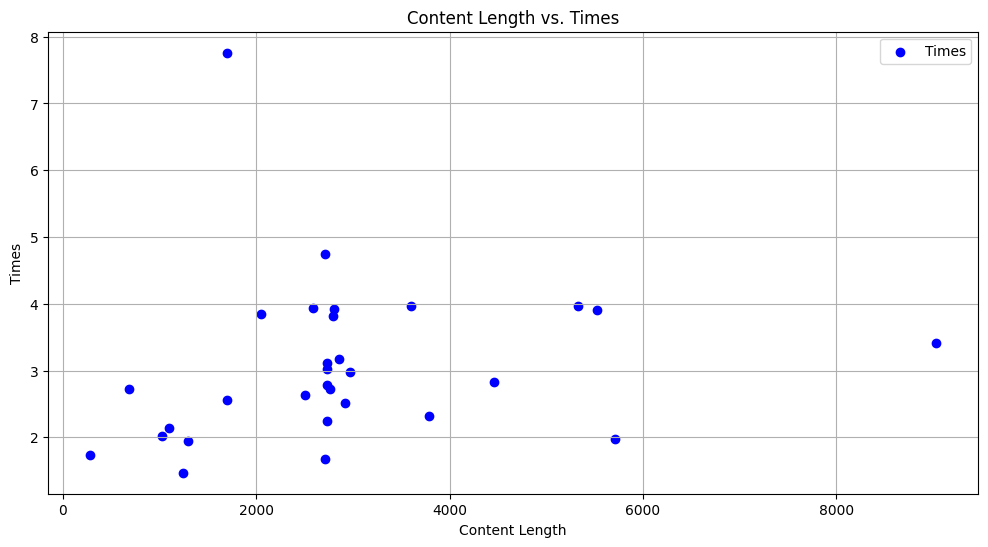

In [56]:
import matplotlib.pyplot as plt

# Your data
content_length = [3793, 9028, 1244, 2919, 1097, 5527, 288, 2730, 5707, 686, 2049, 2861, 3604, 2732, 2796, 5328, 2737, 2510, 2802, 2591, 2976, 2733, 2760, 4464, 1033, 2714, 2715, 1703, 1696, 1296]
times = [2.32, 3.42, 1.47, 2.52, 2.14, 3.91, 1.73, 3.12, 1.97,  2.73, 3.85, 3.17, 3.97, 3.03, 3.82, 3.96, 2.24, 2.64, 3.92, 3.93, 2.98, 2.78, 2.73, 2.83, 2.02, 4.75, 1.67, 2.56, 7.76, 1.95]
print(len(content_length))
print(len(times))
# Plotting the graph
plt.figure(figsize=(12, 6))
plt.scatter(content_length, times, color='blue', label='Times')
plt.xlabel('Content Length')
plt.ylabel('Times')
plt.title('Content Length vs. Times')
plt.legend()
plt.grid(True)
plt.show()

Sentiment Analysis

In [30]:
def test_sentiment_analysis():

    sentiment_analysis_actual = []
    sentiment_analysis_predicted = []

    count = 0

    for company in data["companies"]:
      print("Name:", company["name"])
      content_count = 0
      for article in company["articles"]:
          messages=[{"role": "system", "content": prompt}]
          messages.append({"role":"user", "content":article["content"]})
          content_count += len(article["content"])
          sentiment_analysis_actual.append(article["stock_news_sentiment"])
          client = OpenAI()
          completion = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages = messages,
            temperature=1,
            functions = function,
            function_call='auto'
          )

          # count = count + 1
          # print(f"Article number processed: {count}")

          args = completion.choices[0].message.function_call.arguments
          try:
              output = json.loads(args)
              # print(output)
              sentiment_analysis_predicted.append(output['sentiment'])
          except:
              print ("Incorrect JSON format returned.")
              time.sleep(10)
      print(f"Total Content length: {content_count}")
    return sentiment_analysis_actual, sentiment_analysis_predicted

In [209]:
%%time
sentiment_analysis_actual, sentiment_analysis_predicted = test_sentiment_analysis()

Name: NVIDIA
Total Content length: 14065
Name: Palantir Technologies
Total Content length: 18268
Name: Duolingo
Total Content length: 25303
Name: Beyond Meat
Total Content length: 24788
Name: Advanced Micro Devices AMD
Total Content length: 4668
CPU times: user 2.59 s, sys: 18.9 ms, total: 2.6 s
Wall time: 18.3 s


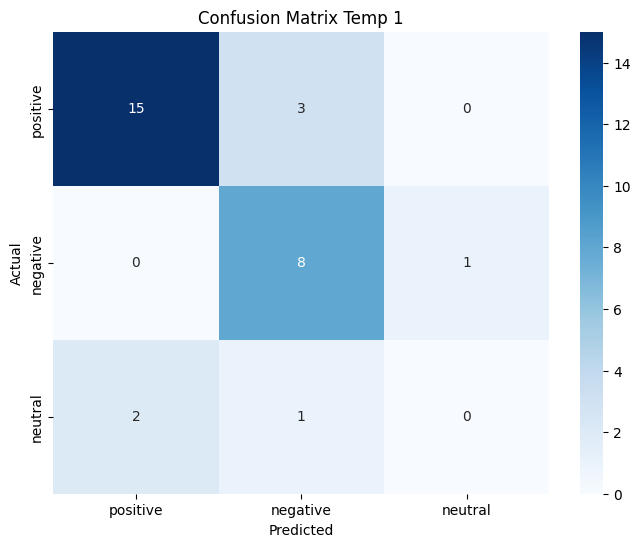

In [114]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Actual and predicted lists
actual = sentiment_analysis_actual
predicted = sentiment_analysis_predicted

# Define the categories
categories = ["positive", "negative", "neutral"]

# Create confusion matrix
cm = confusion_matrix(actual, predicted, labels=categories)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=categories, yticklabels=categories, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix Temp 1")
plt.show()